In [10]:
import numpy as np
import os
import sys
import astropy.units as u
import astropy.constants as constants
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

kl_path = '/Users/sweveret/repos/KLens'
sys.path.insert(0, kl_path)
from tfCube2 import GalaxyImage, TFCube

tk_path = '/Users/sweveret/repos/kl-tools/kl_tools'
sys.path.insert(0, tk_path)
from velocity import VelocityMap
from utils import build_map_grid

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Mutual Parameters

In [11]:
# sampled_pars = {
#     'g1': 0.05,
#     'g2': -0.025,
#     'theta_int': np.pi / 3,
#     'sini': 0.8,
#     'v0': 10.,
#     'vcirc': 200,
#     'rscale': 5,
# }
sampled_pars = {
    'g1': 0.05,
    'g2': -0.025,
#     'g1': 0.0,
#     'g2': 0.0,
    'theta_int': np.pi / 3,
    'sini': 0.8,
    'v0': 10.,
    'vcirc': 200,
    'rscale': 5,
}

im_pars = {
    'flux': 1e5,
    'hlr': 5,
}

pars = {
    'redshift': 0.3,
    'resolution': 5000,
    'pixel_scale': 1., # to simplify a few things
    'Nx': 100,
    'Ny': 100,
    'psf': {
        'type': 'Gaussian', # Matches what is in tfCube
        'fwhm': 3, # arcsec
    },
    'v_unit': u.Unit('km/s'),
    'r_unit': u.Unit('pix')
}

## Setup TFCube Parameters

In [12]:
tf_pars = {}

keys = ['g1', 'g2', 'theta_int', 'sini', 'vcirc']
for key in keys:
    tf_pars[key] = sampled_pars[key]
    
tf_pars['v_0'] = sampled_pars['v0']
tf_pars['vscale'] = sampled_pars['rscale']
tf_pars['r_0'] = 0.
    
tf_pars['redshift'] = pars['redshift']
tf_pars['Resolution'] = pars['resolution']
tf_pars['psfFWHM'] = pars['psf']['fwhm']
tf_pars['pixScale'] = pars['pixel_scale']
tf_pars['r_hl_image'] = im_pars['hlr']
tf_pars['r_hl_spec'] = im_pars['hlr']
tf_pars['aspect'] = 0.1 # galsim default

    
assert pars['Nx'] == pars['Ny']
tf_pars['ngrid'] = pars['Nx']
tf_pars['image_size'] = pars['Nx']
    
line_species='Halpha'

In [4]:
TF = TFCube(pars=tf_pars, line_species=line_species)
print(TF.Pars.fid)
print(vars(TF).keys())

{'g1': 0.05, 'g2': -0.025, 'sini': 0.8, 'redshift': 0.3, 'vcirc': 200, 'vscale': 5, 'v_0': 10.0, 'r_0': 0.0, 'sigma_intr': 0.01, 'r_hl_image': 5, 'r_hl_spec': 5, 'aspect': 0.1, 'knot_fraction': 0.0, 'diskFrac': 1.0, 'n_knots': 25, 'theta_int': 1.0471975511965976, 'linelist': array([('OIIa', 372.7092, 4.24413182e-17),
       ('OIIb', 372.9875, 4.24413182e-17),
       ('OIIIa', 496.0295, 4.24413182e-17),
       ('OIIIb', 500.824 , 4.24413182e-17),
       ('Halpha', 656.461 , 1.00000000e-15)],
      dtype=[('species', '<U16'), ('lambda', '<f8'), ('flux', '<f8')]), 'lambda0': 656.461, 'lambda_cen': 853.3993, 'lambda_min': 851.3993, 'lambda_max': 855.3993, 'norm': 0.0, 'ngrid': 100, 'image_size': 100, 'pixScale': 1.0, 'nm_per_pixel': 0.033, 'offset_x': 0.0, 'offset_y': 0.0, 'type_of_observations': 'slit', 'slitAngles': array([0.        , 1.57079633]), 'slitWidth': 0.12, 'psfFWHM': 3, 'psf_g1': 0.0, 'psf_g2': 0.0, 'area': 785000.0, 'Resolution': 5000, 'expTime': 1800.0, 'throughput': 0.29, '

In [5]:
# for key, val in vars(TF).items():
#     print(f'{key}: {val}')

## Make Velocity Maps

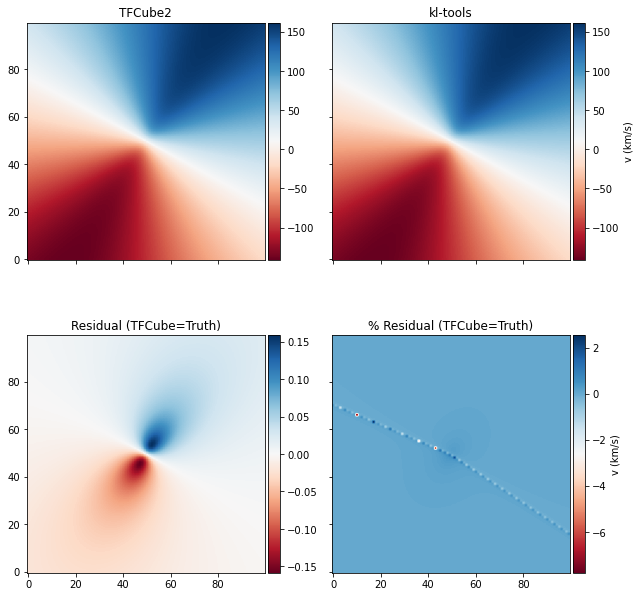

In [6]:
# TFCube
c_kms = constants.c.to('km / s').value
tf_vmap = c_kms * TF.getVmap(tf_pars['vcirc'],
                  tf_pars['sini'],
                  tf_pars['g1'],
                  tf_pars['g2'],
                  tf_pars['vscale'],
                  tf_pars['v_0'],
                  tf_pars['r_0'],
                  tf_pars['theta_int']
                 )

# kl-tools
vmap_units = {
    'v_unit': pars['v_unit'],
    'r_unit': pars['r_unit']
}
vmap_pars = {**sampled_pars, **vmap_units}
kl_Vmap = VelocityMap('default', vmap_pars)
X, Y = build_map_grid(pars['Nx'], pars['Ny'])
kl_vmap = kl_Vmap('obs', X, Y, normalized=False)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                        figsize=(9,9), facecolor='w')

vmaps = [tf_vmap, kl_vmap, tf_vmap-kl_vmap, 100*(tf_vmap-kl_vmap)/kl_vmap]
titles = ['TFCube2', 'kl-tools', 'Residual (TFCube=Truth)', '% Residual (TFCube=Truth)']

for i in range(4):
    ax = axes[i//2, i%2]
    if i == 4-1:
        vmin, vmax = None, None
    else:
        vmin, vmax = None, None
    im = ax.imshow(vmaps[i], origin='lower', vmin=vmin, vmax=vmax, cmap='RdBu')
    ax.set_title(titles[i])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if i % 2 == 1:
        label = 'v (km/s)'
    else:
        label = None
    plt.colorbar(im, cax=cax, label=label)
#     plt.colorbar(im, ax=ax)
    
plt.tight_layout()

In [7]:
print(kl_Vmap.model.pars)
print(TF.Pars.fid)

{'g1': 0.05, 'g2': -0.025, 'theta_int': 1.0471975511965976, 'sini': 0.8, 'v0': 10.0, 'vcirc': 200, 'rscale': 5, 'v_unit': Unit("km / s"), 'r_unit': Unit("pix")}
{'g1': 0.05, 'g2': -0.025, 'sini': 0.8, 'redshift': 0.3, 'vcirc': 200, 'vscale': 5, 'v_0': 10.0, 'r_0': 0.0, 'sigma_intr': 0.01, 'r_hl_image': 5, 'r_hl_spec': 5, 'aspect': 0.1, 'knot_fraction': 0.0, 'diskFrac': 1.0, 'n_knots': 25, 'theta_int': 1.0471975511965976, 'linelist': array([('OIIa', 372.7092, 4.24413182e-17),
       ('OIIb', 372.9875, 4.24413182e-17),
       ('OIIIa', 496.0295, 4.24413182e-17),
       ('OIIIb', 500.824 , 4.24413182e-17),
       ('Halpha', 656.461 , 1.00000000e-15)],
      dtype=[('species', '<U16'), ('lambda', '<f8'), ('flux', '<f8')]), 'lambda0': 656.461, 'lambda_cen': 853.3993, 'lambda_min': 851.3993, 'lambda_max': 855.3993, 'norm': 0.0, 'ngrid': 100, 'image_size': 100, 'pixScale': 1.0, 'nm_per_pixel': 0.033, 'offset_x': 0.0, 'offset_y': 0.0, 'type_of_observations': 'slit', 'slitAngles': array([0.    

/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_70526/1476537722.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(TF.X, TF.Y, tf_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_70526/1476537722.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X, Y, kl_vmap, cmap='RdBu')
/var/folders/92/vynp_rhj5v555c18dmsmnrpc0000gq/T/ipykernel_70526/1476537722.py:19: MatplotlibDeprecationWarning: 

Text(0.5, 1.0, 'Residual (TFCube = truth)')

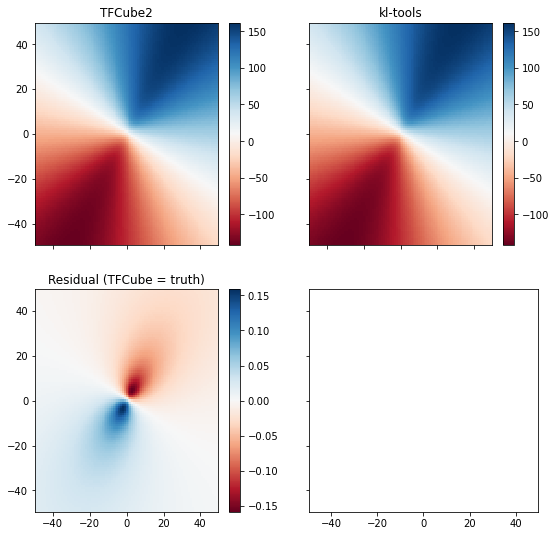

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(9,9))

# ax = axes[0,0]
plt.subplot(221)
plt.pcolormesh(TF.X, TF.Y, tf_vmap, cmap='RdBu')
plt.colorbar()
plt.title('TFCube2')

plt.subplot(222)
plt.pcolormesh(X, Y, kl_vmap, cmap='RdBu')
plt.colorbar()
plt.title('kl-tools')

assert (X == TF.X).all()
assert (Y == TF.Y).all()

plt.subplot(223)
plt.pcolormesh(X, Y, kl_vmap-tf_vmap, cmap='RdBu')
plt.colorbar()
plt.title('Residual (TFCube = truth)')

In [9]:
TF.X == X

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])